## Dogs v Cats

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

import skimage

In [14]:
PATH = "/data/dogcat/dogscats/"
sz = 224
arch = resnet34
bs = 64

In [15]:
m = arch(True)

In [16]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [17]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [18]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [19]:
learn = ConvLearner.from_model_data(m, data)

In [20]:
learn.freeze_to(-4)

In [21]:
m[-1].trainable

True

In [22]:
m[-4].trainable

True

In [23]:
m[-5].trainable

False

In [24]:
learn.fit(0.01, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.145836   0.110693   0.988     



[array([0.11069]), 0.988]

In [25]:
learn.fit(0.01, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.084535   0.101306   0.988     



[array([0.10131]), 0.988]

## Class Activation Maps (CAM)

In [26]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [27]:
x,y = next(iter(data.val_dl))

In [28]:
x,y = x[None,1], y[None,1]
vx = Variable(x.cuda(), requires_grad=True)

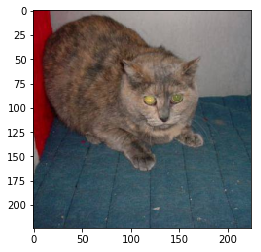

In [29]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [30]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

In [31]:
%time py = m(Variable(x.cuda()))

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 11.4 ms


In [32]:
for o in sfs: o.remove()

In [33]:
[o.features.size() for o in sfs]

[torch.Size([1, 128, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 512, 7, 7]),
 torch.Size([1, 2, 7, 7])]

In [34]:
py = np.exp(to_np(py)[0]); py

array([1., 0.], dtype=float32)

In [35]:
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape

(2, 7, 7)

In [36]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[0.15799, 0.27391, 0.32684, 0.33489, 0.3322 , 0.29834, 0.19853],
       [0.21186, 0.41522, 0.56571, 0.61278, 0.62855, 0.55026, 0.35301],
       [0.21985, 0.50154, 0.77281, 0.90181, 0.93245, 0.78371, 0.46785],
       [0.19414, 0.4881 , 0.82174, 1.     , 0.99563, 0.76116, 0.41222],
       [0.12289, 0.3602 , 0.67074, 0.84041, 0.78965, 0.53787, 0.25068],
       [0.04298, 0.16261, 0.34363, 0.43601, 0.37253, 0.19501, 0.05436],
       [0.     , 0.02274, 0.08375, 0.10852, 0.0727 , 0.     , 0.     ]], dtype=float32)

/data/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/data/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


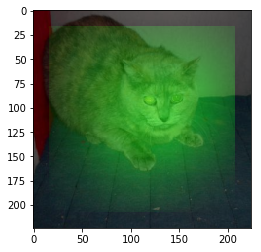

In [37]:
plt.imshow(dx)
plt.imshow(skimage.transform.resize(f2, dx.shape), alpha=0.5, cmap='hot');

## Model

In [38]:
learn.unfreeze()
learn.bn_freeze(True)

In [39]:
# 12 layer groups call for 12 lrs
lr=np.array([[1e-6]*4,[1e-4]*4,[1e-2]*4]).flatten()

In [40]:
learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.068001   0.046923   0.99      
    1      0.029877   0.040114   0.99                         



[array([0.04011]), 0.99]

In [41]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

0.994

In [42]:
learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.026316   0.03864    0.989     
    1      0.025401   0.035233   0.991                        



[array([0.03523]), 0.991]

In [43]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

0.993